In [1]:
import scipy.io as sio
import torch
import glob
import numpy
import torch.nn.functional as F
def get_freq(indices):
    freq = torch.zeros(8192)
    indices = indices.flatten()
    for indice in indices:
        freq[indice] += 1
    return freq

# # 统计所有indice出现的频次，直方图
# root_path = '../work_dirs/anal/val'
root_path = '../work_dirs/mask_vqseg_agg_swin_large_patch4_window12_768x768_pretrain_384x384_22K_300e_cityscapes/annal'
list = glob.glob(root_path + '/*')

data = sio.loadmat(list[7])
print(data.keys())
print('semantic_seg_pred', data['semantic_seg_pred'].shape)
print('gt_semantic_seg', data['gt_semantic_seg'].shape)
print('vq_indices', data['vq_indices'].shape)
print('vq_indice_gt', data['vq_indice_gt'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'semantic_seg_pred', 'gt_semantic_seg', 'vq_indices', 'vq_indice_gt'])
semantic_seg_pred (1, 1, 1024, 2048)
gt_semantic_seg (1, 1, 1024, 2048)
vq_indices (1, 1, 128, 256)
vq_indice_gt (1, 1, 128, 256)


In [89]:
from IPython.display import display, Image

freq = get_freq(data['vq_indice_gt'])
# print('gt sum', freq.sum().item())
freq[freq != 0] = 1
print('gt indices中描述gt seg mask所用到的indice数量', freq.sum().item())
print()
pred_freq = get_freq(data['vq_indices'])
# print('gt sum', pred_freq.sum().item())
pred_freq[pred_freq != 0] = 1
print('pred indices中描述gt seg mask所用到的indice数量', pred_freq.sum().item())

gt indices中描述gt seg mask所用到的indice数量 2810.0

pred indices中描述gt seg mask所用到的indice数量 491.0


In [60]:
def draw_segmap_from_indice(indice):
    return encode_to_segmap(F.interpolate(torch.tensor(indice).float(), size=data['gt_semantic_seg'].shape[-2:], mode='nearest'))[0].permute(1, 2, 0)

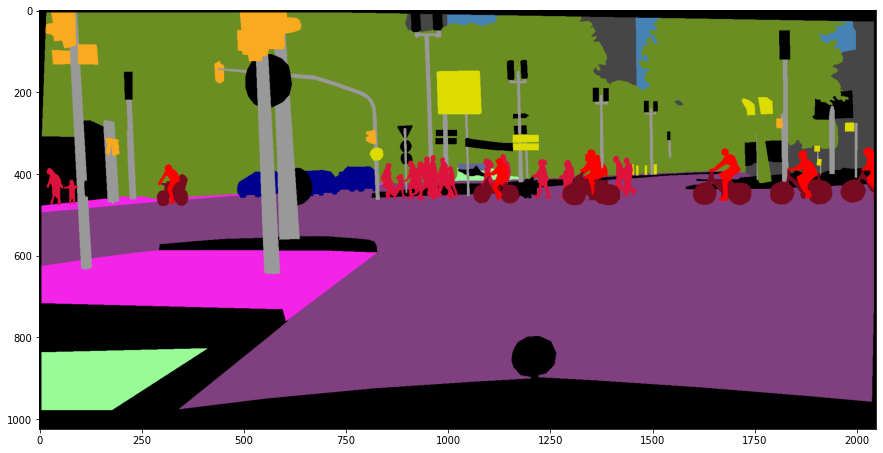

In [90]:
import matplotlib.pyplot as plt
import torch
from mmseg.models.utils.dalle_d_vae import get_dalle_vae, map_pixels, unmap_pixels, encode_to_segmap, decode_from_segmap
plt.figure(figsize=(15,10))
gt_seg_map = draw_segmap_from_indice(data['gt_semantic_seg'])
pred_seg_map = draw_segmap_from_indice(data['semantic_seg_pred'])
plt.imshow(gt_seg_map)
# print(data['gt_semantic_seg'])

plt.show()


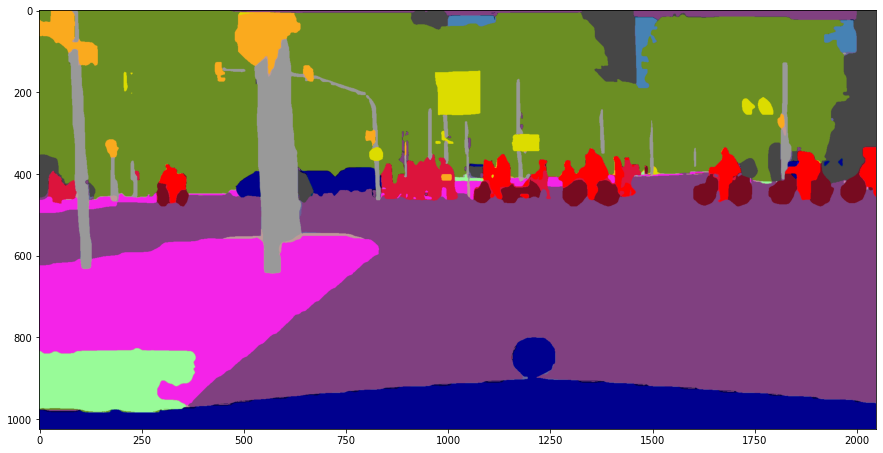

In [91]:
plt.figure(figsize=(15,10))
plt.imshow(pred_seg_map)
plt.show()

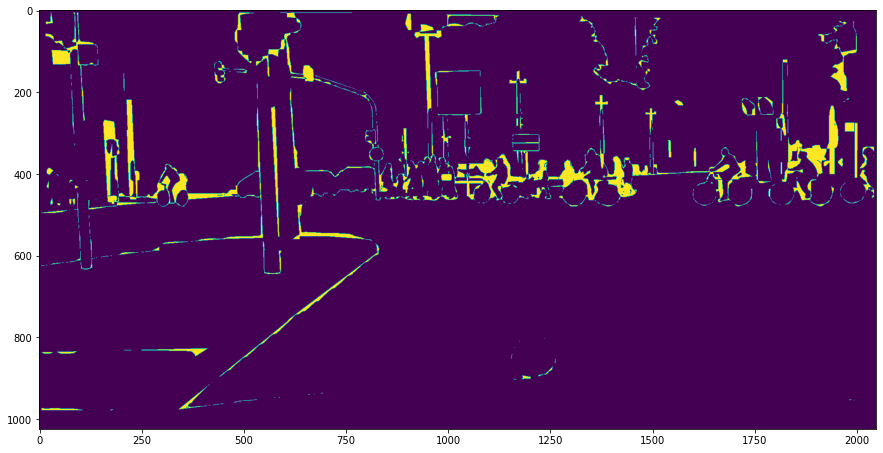

In [92]:
pixel_error_map = torch.ones_like(torch.tensor(data['gt_semantic_seg']))
pixel_error_map[torch.tensor(data['gt_semantic_seg'] != data['semantic_seg_pred'])] = 0
pixel_error_map[torch.tensor(data['gt_semantic_seg'] >= 19)] = 1

plt.figure(figsize=(15,10))
plt.imshow(1 - pixel_error_map[0,0])
plt.show()

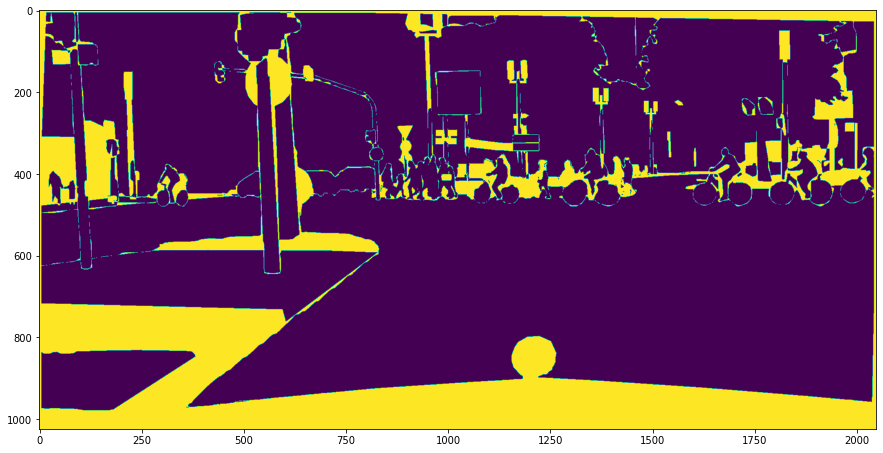

In [93]:
# input
gt_semantic_seg = torch.tensor(data['gt_semantic_seg'])
pred_pixel = torch.tensor(data['semantic_seg_pred'])
gt_vq_indices = torch.tensor(data['vq_indice_gt'])

# process
relaxation_map = torch.ones_like(gt_semantic_seg, device=gt_semantic_seg.device)
relaxation_map[pred_pixel == gt_semantic_seg] = 0
# relaxation
# relaxation_map = F.avg_pool2d(relaxation_map.float(), kernel_size=(16, 16), stride=(8, 8))
# relaxation_map = F.interpolate(relaxation_map.float(), size=gt_vq_indices.shape[-2:], mode='bilinear')
# relaxation_map[relaxation_map >= 0.02] = 1
# relaxation_map[relaxation_map < 1] = 0
# 1的区域是要监督的，0的区域是不用监督的

plt.figure(figsize=(15,10))
plt.imshow((relaxation_map[0,0])) #  * gt_vq_indices[0,0])
plt.show()
# print(mask[])

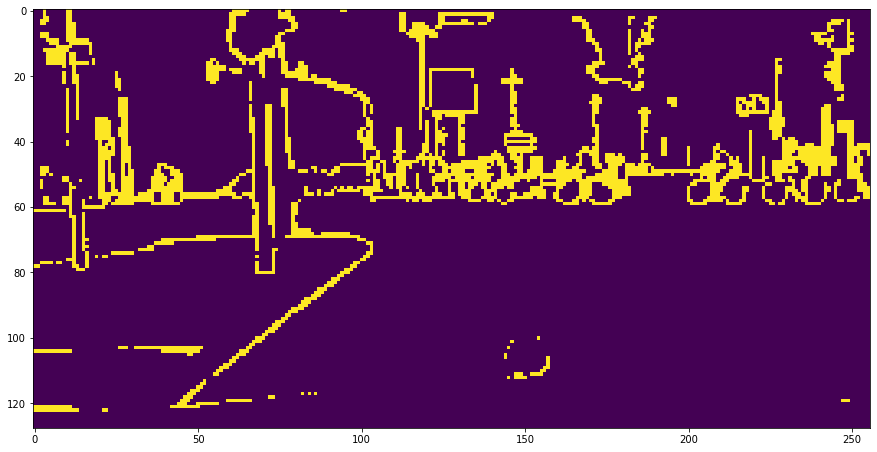

In [65]:
# input
gt_semantic_seg = torch.tensor(data['gt_semantic_seg'])
pred_pixel = torch.tensor(data['semantic_seg_pred'])
gt_vq_indices = torch.tensor(data['vq_indice_gt'])

# process
relaxation_map = torch.ones_like(gt_semantic_seg, device=gt_semantic_seg.device)
relaxation_map[pred_pixel == gt_semantic_seg] = 0
relaxation_map[gt_semantic_seg >= 19] = 0
# relaxation
relaxation_map = F.max_pool2d(relaxation_map.float(), kernel_size=(8, 8), stride=(8, 8))
# relaxation_map = F.avg_pool2d(relaxation_map.float(), kernel_size=(16, 16), stride=(1, 1))
# relaxation_map = F.interpolate(relaxation_map.float(), size=gt_vq_indices.shape[-2:], mode='bilinear')
# relaxation_map[relaxation_map >= 0.01] = 1
# relaxation_map[relaxation_map < 1] = 0
# 1的区域是要监督的，0的区域是不用监督的

# plt.figure(figsize=(15,10))
# plt.imshow((relaxation_map[0,0])) #  * gt_vq_indices[0,0])
# plt.show()
# print(mask[])
indice_error_map = torch.ones_like(torch.tensor(data['vq_indices']))
indice_error_map[torch.tensor(data['vq_indices'] != data['vq_indice_gt'])] = 0

plt.figure(figsize=(15,10))
plt.imshow((relaxation_map[0,0] * (1 - indice_error_map[0,0]))) #  * gt_vq_indices[0,0])
plt.show()

/home/chenjiaqi/anaconda3/envs/mmseg/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


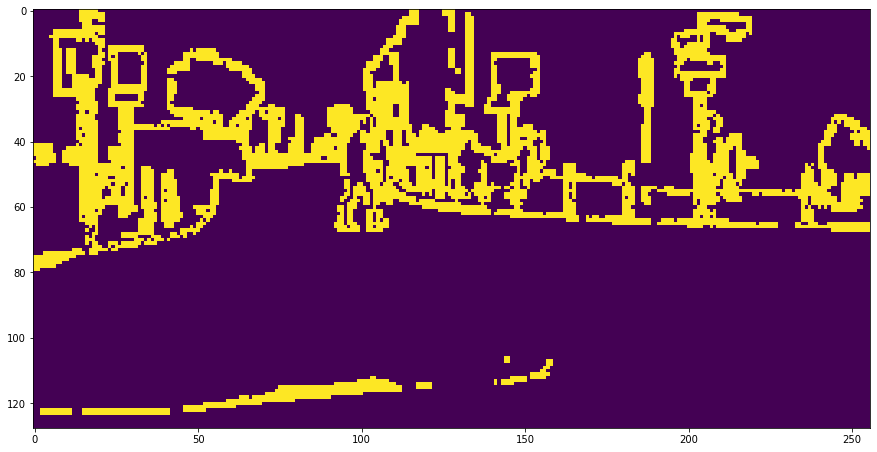

In [9]:
# input
gt_semantic_seg = torch.tensor(data['gt_semantic_seg'])
pred_pixel = torch.tensor(data['semantic_seg_pred'])
gt_vq_indices = torch.tensor(data['vq_indice_gt'])

# process
relaxation_map = torch.ones_like(gt_semantic_seg, device=gt_semantic_seg.device)
relaxation_map[pred_pixel == gt_semantic_seg] = 0
relaxation_map[gt_semantic_seg >= 19] = 0
# relaxation
# indice_map_mask = F.max_pool2d(ignore_map.float(), kernel_size=(8, 8), stride=(8, 8))
relaxation_map = F.avg_pool2d(relaxation_map.float(), kernel_size=(16, 16), stride=(1, 1))
relaxation_map = F.interpolate(relaxation_map.float(), size=gt_vq_indices.shape[-2:], mode='bilinear')
relaxation_map[relaxation_map >= 0.01] = 1
relaxation_map[relaxation_map < 1] = 0
# 1的区域是要监督的，0的区域是不用监督的

# plt.figure(figsize=(15,10))
# plt.imshow((relaxation_map[0,0])) #  * gt_vq_indices[0,0])
# plt.show()
# # print(mask[])
indice_error_map = torch.ones_like(torch.tensor(data['vq_indices']))
indice_error_map[torch.tensor(data['vq_indices'] != data['vq_indice_gt'])] = 0

plt.figure(figsize=(15,10))
plt.imshow((relaxation_map[0,0] * (1 - indice_error_map[0,0]))) #  * gt_vq_indices[0,0])
plt.show()

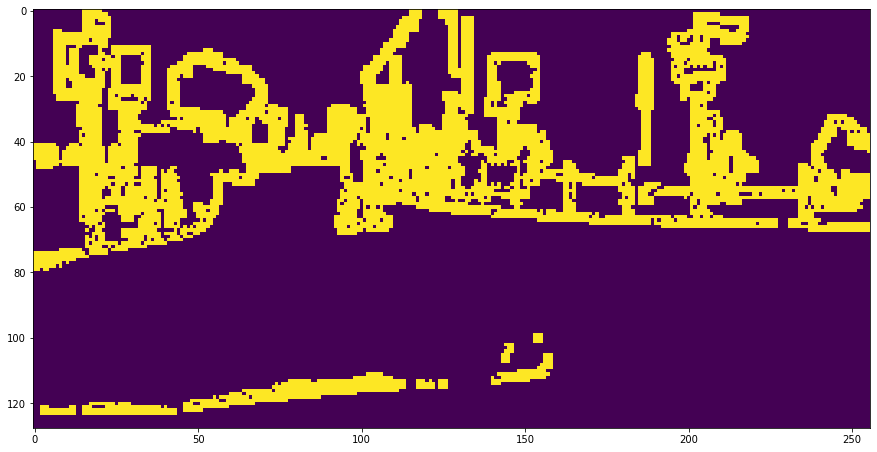

In [10]:
# input
gt_semantic_seg = torch.tensor(data['gt_semantic_seg'])
pred_pixel = torch.tensor(data['semantic_seg_pred'])
gt_vq_indices = torch.tensor(data['vq_indice_gt'])

# process
relaxation_map = torch.ones_like(gt_semantic_seg, device=gt_semantic_seg.device)
relaxation_map[pred_pixel == gt_semantic_seg] = 0
relaxation_map[gt_semantic_seg >= 19] = 0
# relaxation
relaxation_map = F.avg_pool2d(relaxation_map.float(), kernel_size=(16, 16), stride=(8, 8))
relaxation_map = F.interpolate(relaxation_map.float(), size=gt_vq_indices.shape[-2:], mode='bilinear')
relaxation_map[relaxation_map >= 0.0001] = 1
relaxation_map[relaxation_map < 1] = 0
# 1的区域是要监督的，0的区域是不用监督的

indice_error_map = torch.ones_like(torch.tensor(data['vq_indices']))
indice_error_map[torch.tensor(data['vq_indices'] != data['vq_indice_gt'])] = 0

plt.figure(figsize=(15,10))
plt.imshow((relaxation_map[0,0] * (1 - indice_error_map[0,0]))) #  * gt_vq_indices[0,0])
plt.show()

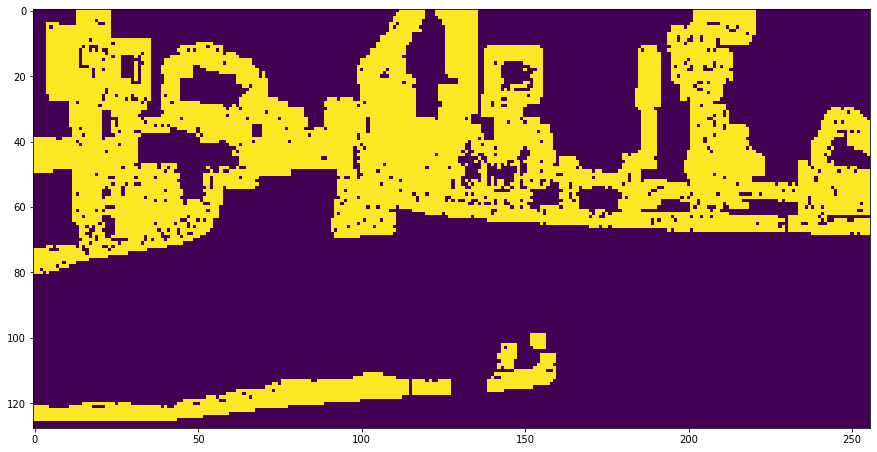

In [11]:
# input
gt_semantic_seg = torch.tensor(data['gt_semantic_seg'])
pred_pixel = torch.tensor(data['semantic_seg_pred'])
gt_vq_indices = torch.tensor(data['vq_indice_gt'])

# process
relaxation_map = torch.ones_like(gt_semantic_seg, device=gt_semantic_seg.device)
relaxation_map[pred_pixel == gt_semantic_seg] = 0
relaxation_map[gt_semantic_seg >= 19] = 0
# relaxation
relaxation_map = F.avg_pool2d(relaxation_map.float(), kernel_size=(32, 32), stride=(8, 8))
relaxation_map = F.interpolate(relaxation_map.float(), size=gt_vq_indices.shape[-2:], mode='bilinear')
relaxation_map[relaxation_map >= 0.0001] = 1
relaxation_map[relaxation_map < 1] = 0
# 1的区域是要监督的，0的区域是不用监督的

indice_error_map = torch.ones_like(torch.tensor(data['vq_indices']))
indice_error_map[torch.tensor(data['vq_indices'] != data['vq_indice_gt'])] = 0

plt.figure(figsize=(15,10))
plt.imshow((relaxation_map[0,0] * (1 - indice_error_map[0,0]))) #  * gt_vq_indices[0,0])
plt.show()

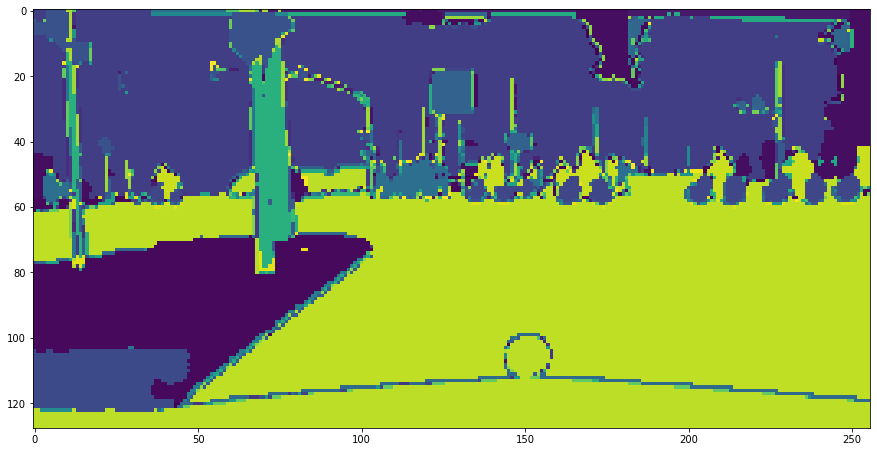

In [94]:
plt.figure(figsize=(15,10))
plt.imshow(data['vq_indices'][0,0])
plt.show()

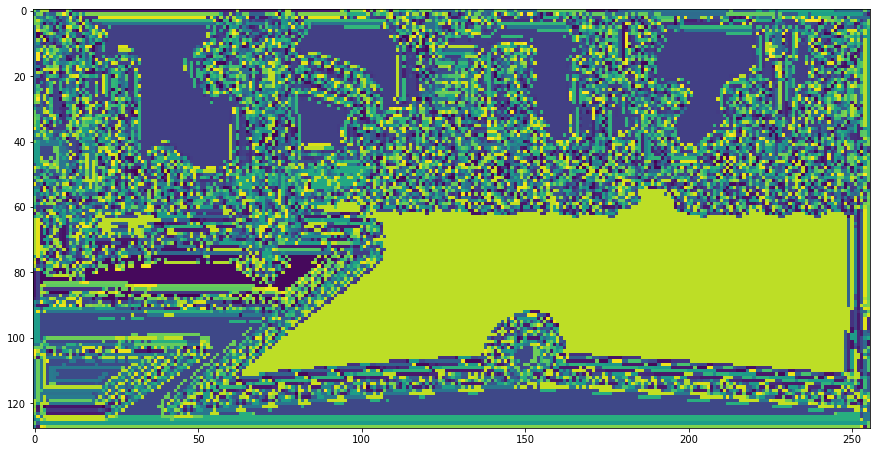

In [82]:
plt.figure(figsize=(15,10))
plt.imshow(data['vq_indice_gt'][0,0])
plt.show()

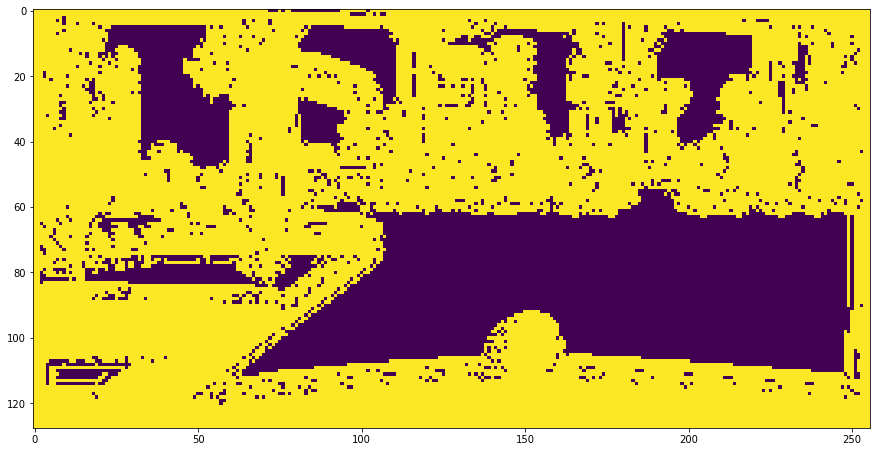

In [95]:
indice_error_map = torch.ones_like(torch.tensor(data['vq_indices']))
indice_error_map[torch.tensor(data['vq_indices'] != data['vq_indice_gt'])] = 0
# indice_error_map[torch.tensor(data['vq_indices'] >= 19)] = 1

plt.figure(figsize=(15,10))
plt.imshow(1 - indice_error_map[0,0])
plt.show()

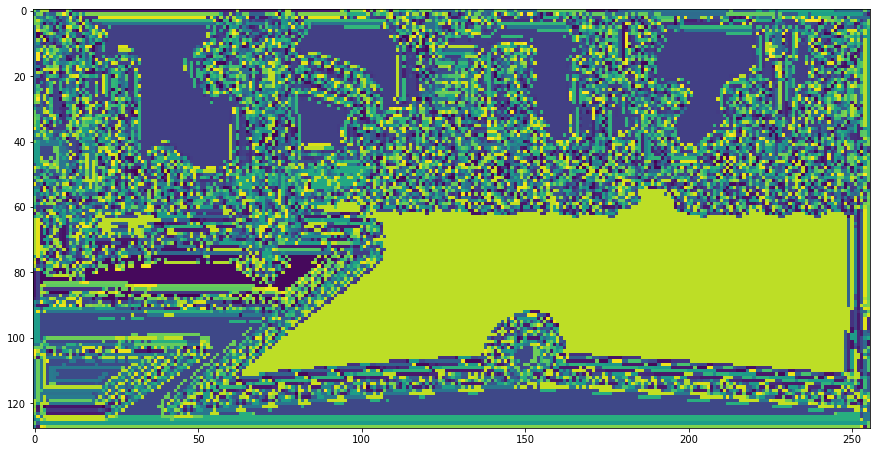

In [69]:
plt.figure(figsize=(15,10))
plt.imshow(data['vq_indice_gt'][0,0])
plt.show()

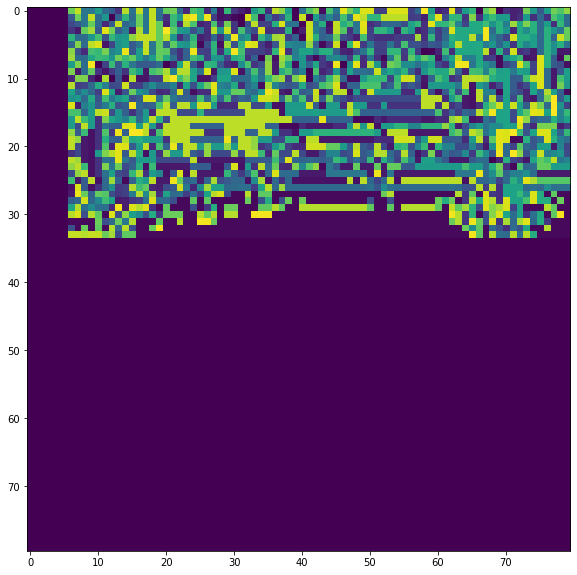

In [70]:
plt.figure(figsize=(15,10))
img = data['vq_indice_gt'][0,0,-80:, :80]
mask = torch.ones_like(gt_seg_map[-80:, :80])
mask[gt_seg_map[-80:, :80] == 0] = 0
plt.imshow(mask[:,:,0] * img)
plt.show()
# print(data['vq_indice_gt'][0,0, -40:-10, :20])

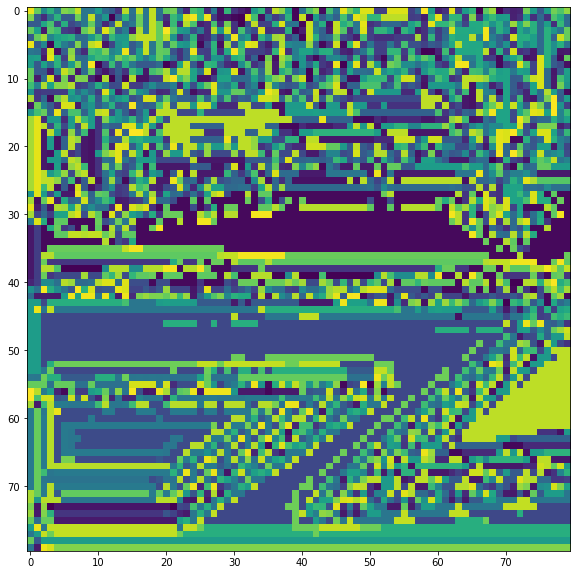

In [71]:
plt.figure(figsize=(15,10))
img = data['vq_indice_gt'][0,0,-80:, :80]
mask = torch.ones_like(gt_seg_map[-80:, :80])
mask[gt_seg_map[-80:, :80] == 0] = 0
plt.imshow(img)
plt.show()

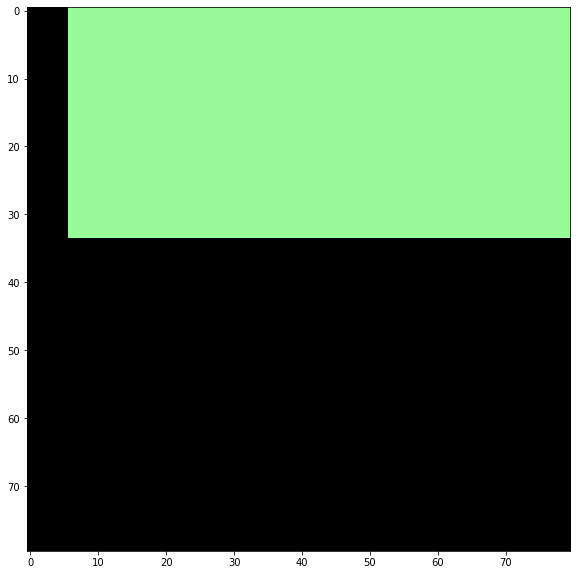

torch.Size([80, 80, 3])


In [72]:
plt.figure(figsize=(15,10))
plt.imshow(gt_seg_map[-80:, :80])
plt.show()
print(gt_seg_map[-80:, :80].shape)
# print(data['vq_indice_gt'][0,0, -40:-10, :20])

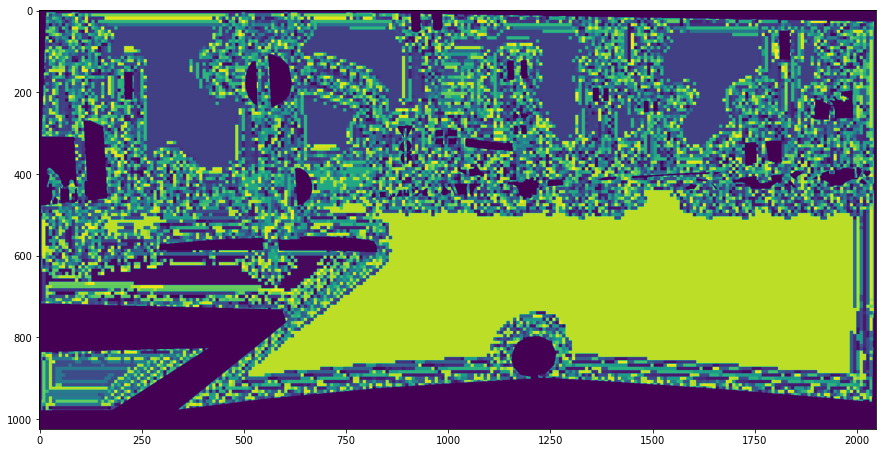

In [73]:
# ignore area mask
indice_error_map = torch.zeros_like(torch.tensor(data['gt_semantic_seg']))
# indice_error_map[torch.tensor(data['vq_indices'] != data['vq_indice_gt'])] = 0
indice_error_map[torch.tensor(data['gt_semantic_seg'] >= 19)] = 1

# gt indice
indice = data['vq_indice_gt']
indice = F.interpolate(torch.tensor(indice).float(), size=indice_error_map.shape[-2:], mode='nearest')
indice *= (1 - indice_error_map)
plt.figure(figsize=(15,10))
plt.imshow(indice[0,0])
plt.show()

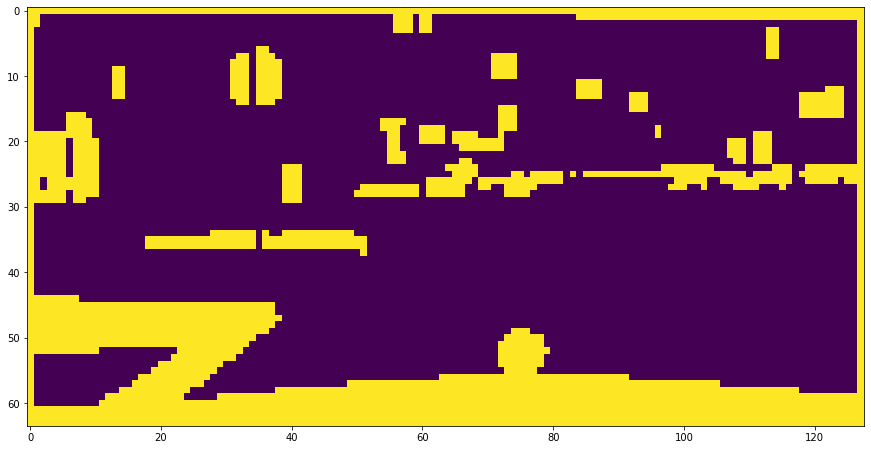

In [74]:
indice_error_map = torch.zeros_like(torch.tensor(data['gt_semantic_seg']))
# indice_error_map[torch.tensor(data['vq_indices'] != data['vq_indice_gt'])] = 0
indice_error_map[torch.tensor(data['gt_semantic_seg'] >= 19)] = 1
indice_error_map = F.max_pool2d(indice_error_map.float(), kernel_size=(16, 16), stride=(16, 16))
plt.figure(figsize=(15,10))
plt.imshow(indice_error_map[0,0])
plt.show()

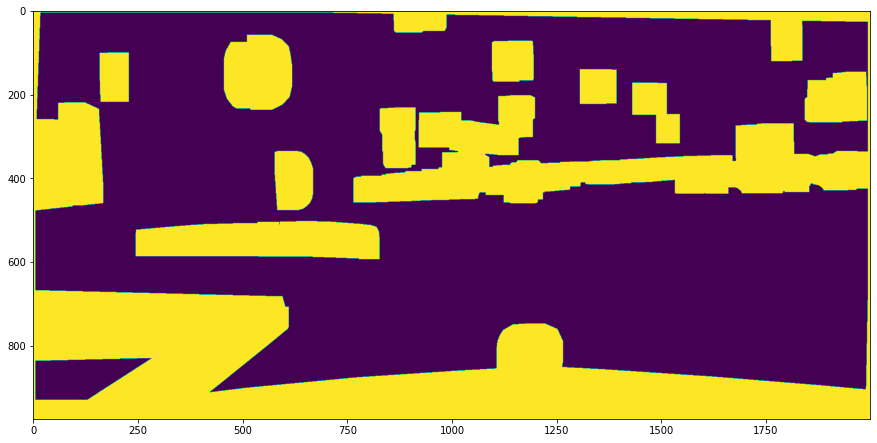

In [75]:
indice_error_map = torch.zeros_like(torch.tensor(data['gt_semantic_seg']))
# indice_error_map[torch.tensor(data['vq_indices'] != data['vq_indice_gt'])] = 0
indice_error_map[torch.tensor(data['gt_semantic_seg'] >= 19)] = 1
indice_error_map = F.avg_pool2d(indice_error_map.float(), kernel_size=(50, 50), stride=(1, 1))
indice_error_map[indice_error_map > 0] = 1
plt.figure(figsize=(15,10))
plt.imshow(indice_error_map[0,0])
plt.show()
# 

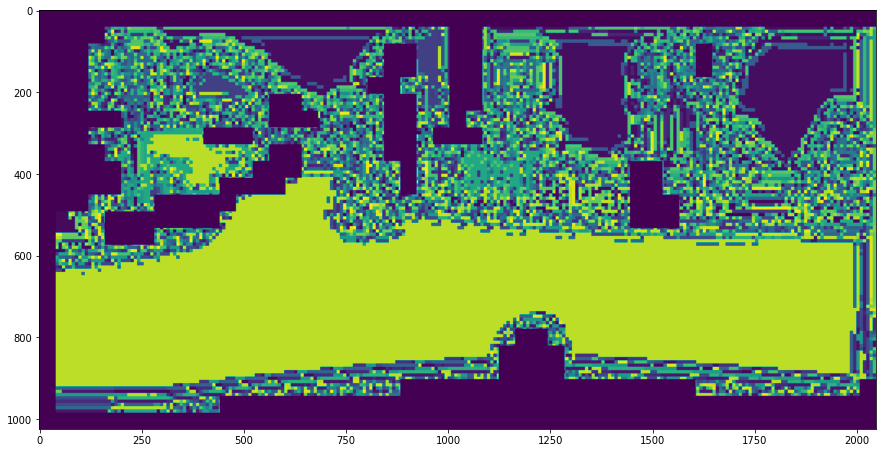

In [21]:
# ignore area mask
indice_error_map = torch.zeros_like(torch.tensor(data['gt_semantic_seg']))
h, w = indice_error_map.shape[-2:]
# indice_error_map[torch.tensor(data['vq_indices'] != data['vq_indice_gt'])] = 0
indice_error_map[torch.tensor(data['gt_semantic_seg'] >= 19)] = 1
ignore_pattern = 40
indice_error_map = F.max_pool2d(indice_error_map.float(), kernel_size=(ignore_pattern, ignore_pattern), stride=(ignore_pattern, ignore_pattern))
indice_error_map = F.interpolate(indice_error_map, size=(h, w), mode='nearest')
# gt indice
indice = data['vq_indice_gt']
indice = F.interpolate(torch.tensor(indice).float(), size=(indice_error_map.shape[-2:]), mode='nearest')
indice *= (1 - indice_error_map)
plt.figure(figsize=(15,10))
plt.imshow(indice[0,0])
plt.show()

1


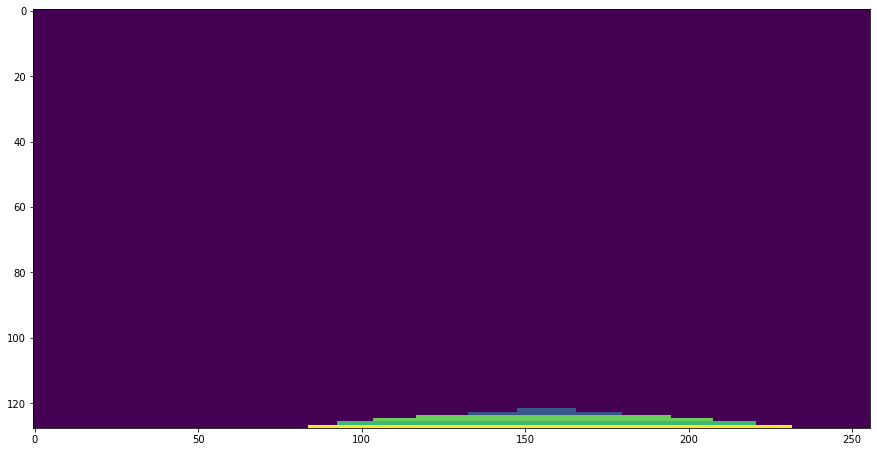

In [22]:
# ignore area mask
indice_error_map = torch.zeros_like(torch.tensor(data['gt_semantic_seg']))
# keep_map = torch.zeros_like(torch.tensor(data['gt_semantic_seg']))
h, w = indice_error_map.shape[-2:]
# indice_error_map[torch.tensor(data['vq_indices'] != data['vq_indice_gt'])] = 0
ignore_area = torch.tensor(data['gt_semantic_seg'] < 19)
indice_error_map[ignore_area] = 1
# keep_map[ignore_area] = 1

indice_error_map = F.avg_pool2d(indice_error_map.float(), kernel_size=(76, 76), stride=(1, 1))
indice_error_map[indice_error_map > 0] = 1
indice_error_map = F.interpolate(indice_error_map, size=(h, w), mode='nearest')

# keep_map = F.avg_pool2d(keep_map.float(), kernel_size=(76, 76), stride=(1, 1))
# keep_map[keep_map < 0.9] = 1
# keep_map[keep_map < 1] = 0
# keep_map = F.interpolate(keep_map.float(), size=(h, w), mode='nearest')
# gt indice
indice = torch.tensor(data['vq_indice_gt']).float()
indice_error_map = F.interpolate(indice_error_map.float(), size=(indice.shape[-2:]), mode='nearest')
# keep_map = F.interpolate(keep_map.float(), size=(indice.shape[-2:]), mode='nearest')
indice *= (1 - indice_error_map)
# indice *= keep_map
plt.figure(figsize=(15,10))
plt.imshow(indice[0,0])
print(1)
plt.show()

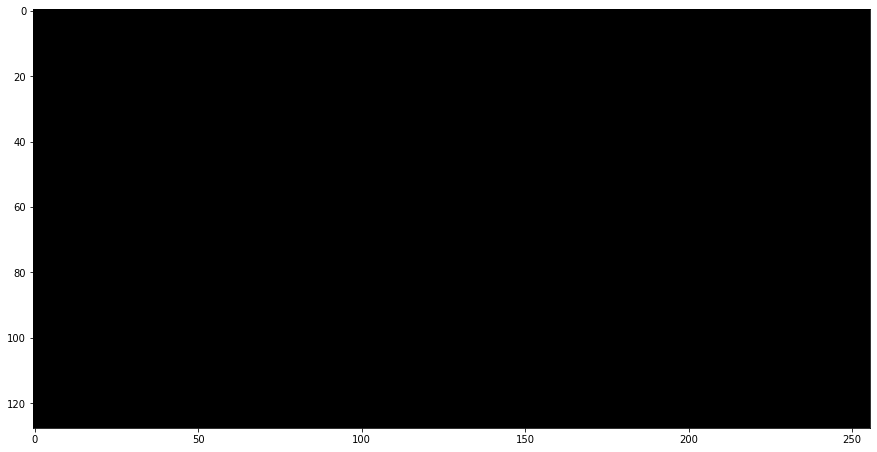

In [23]:
import matplotlib.pyplot as plt
import torch
from mmseg.models.utils.dalle_d_vae import get_dalle_vae, map_pixels, unmap_pixels, encode_to_segmap, decode_from_segmap
plt.figure(figsize=(15,10))
gt = data['gt_semantic_seg']
indice_error_map = F.interpolate(indice_error_map.float(), size=(gt.shape[-2:]), mode='nearest')
gt[indice_error_map == 1] = 255
gt_seg_map = draw_segmap_from_indice(gt)
plt.imshow(gt_seg_map)
plt.show()

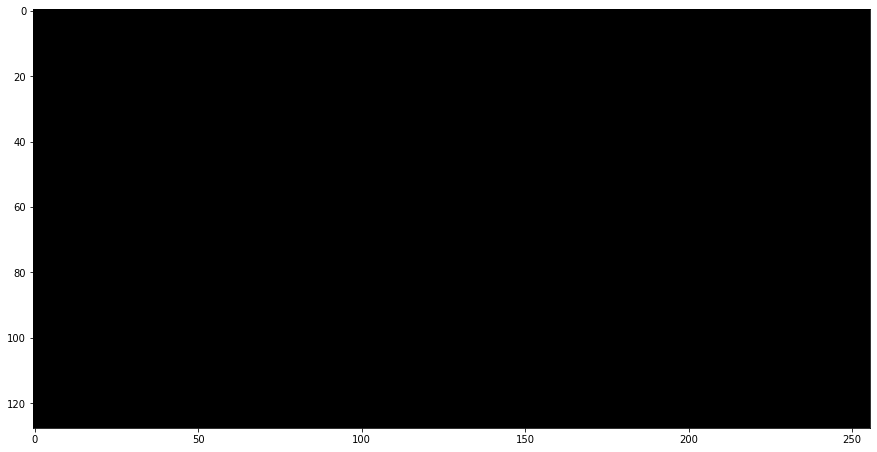

In [24]:
import matplotlib.pyplot as plt
import torch
from mmseg.models.utils.dalle_d_vae import get_dalle_vae, map_pixels, unmap_pixels, encode_to_segmap, decode_from_segmap
plt.figure(figsize=(15,10))
gt_seg_map = draw_segmap_from_indice(data['gt_semantic_seg'])
pred_seg_map = draw_segmap_from_indice(data['semantic_seg_pred'])
indice_error_map = F.interpolate(indice_error_map.float(), size=(gt_seg_map.shape[-2:]), mode='nearest')
plt.imshow(gt_seg_map)


plt.show()

In [25]:
def tensor_dilate(bin_img, ksize=3):
    # 首先为原图加入 padding，防止图像尺寸缩小
    B, C, H, W = bin_img.shape
    pad = (ksize - 1) // 2
    bin_img = F.pad(bin_img, [pad, pad, pad, pad], mode='constant', value=0)
    # 将原图 unfold 成 patch
    patches = bin_img.unfold(dimension=2, size=ksize, step=1)
    patches = patches.unfold(dimension=3, size=ksize, step=1)
    # B x C x H x W x k x k
    # 取每个 patch 中最小的值，i.e., 0
    dilate, _ = patches.reshape(B, C, H, W, -1).max(dim=-1)
    return dilate

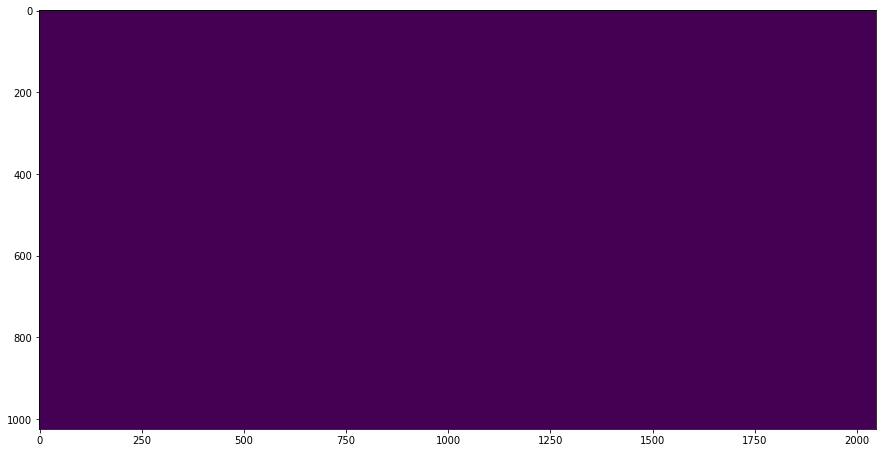

In [26]:
# ignore area mask
indice_error_map = torch.zeros_like(torch.tensor(data['gt_semantic_seg']))
h, w = indice_error_map.shape[-2:]
# indice_error_map[torch.tensor(data['vq_indices'] != data['vq_indice_gt'])] = 0
indice_error_map[torch.tensor(data['gt_semantic_seg'] >= 19)] = 1
ignore_pattern = 3
# indice_error_map = tensor_dilate(indice_error_map, ksize=ignore_pattern)
indice_error_map = F.interpolate(indice_error_map.float(), size=(h, w), mode='nearest')
# gt indice
indice = data['vq_indice_gt']
indice = F.interpolate(torch.tensor(indice).float(), size=(indice_error_map.shape[-2:]), mode='nearest')
indice *= (1 - indice_error_map)
plt.figure(figsize=(15,10))
plt.imshow(indice[0,0])
plt.show()